# 可解释公平指标

## 实验基本环境设置

In [1]:
# 导入依赖
import numpy as np
import pandas as pd
from rich import print
import matplotlib.pyplot as plt
import os

In [2]:
# 字体设置
from pylab import mpl
# 设置显示中文字体
mpl.rcParams["font.sans-serif"] = ["Microsoft YaHei"]

## 自定义函数

In [3]:
# 导入自定义函数
%load_ext autoreload
%autoreload 2
from utils.helper import fairness_metrics, test_model  # 测试各种指标并输出图像
from utils.shap_helper import get_ext_train_comp_by_k
from model.models import train_model_and_test
from mydata.adult_0518 import (
    X_train,
    y_train,
    X_test,
    y_test,
    sex,
    feature_index,
    idxs_loc_male,
    idxs_loc_female,
    X_train_male,
    y_train_male,
    X_train_female,
    y_train_female
)  # 获得 数据集 测试集 和 测试集上的敏感属性

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


In [4]:
import xgboost

xgboost_origin, res_origin = train_model_and_test(
    X_train,
    y_train,
    X_test,
    y_test,
    model_cls=xgboost.XGBRegressor,
    test_func=test_model,
    sensitive_feature=sex,
    desc="原始组",
)
res_origin

{'准确率[1.]': 0.8624219469751254,
 '精确率[1.]': 0.7683765203595981,
 '召回率[1.]': 0.6159389571852479,
 'FPR[0.]': 0.05910931174089069,
 'FNR[0.]': 0.384061042814752,
 'F1 Score[1.]': 0.6837647058823529,
 '人口平等 差异[0.]': 0.16989595884523423,
 '人口平等 比率[1.]': 0.32250719180485066,
 '机会均等 差异[0.]': 0.08764799066199769,
 '机会均等 比率[1.]': 0.29597011190360795}

In [5]:
# 计算得到 shapley values
import shap


def get_shapley_value(model, X_train):
    explainer = shap.Explainer(model)
    shap_values = explainer(X_train)
    return shap_values


shap_values = get_shapley_value(xgboost_origin, X_train)

In [6]:
# 获得 shapley values
shapley_values = shap_values.values
shapley_values.shape

(22792, 14)

In [7]:
# 在 X_train 训练集上，已知 loc 获得 iloc
idxs_iloc_in_X_train_male = X_train.index.get_indexer(idxs_loc_male)
idxs_iloc_in_X_train_female = X_train.index.get_indexer(idxs_loc_female)

In [8]:
# 导入新指标，定义敏感属性
from utils.new_index_0518 import (
    shapley_distance_between_individual_and_individual as sdii,
)
from utils.new_index_0518 import shapley_distance_between_individual_and_group as sdig
from utils.new_index_0518 import shapley_distance_between_group_and_group as sdgg

# 因为 X_train 和 shapley values 是一一对应的，所以可以找到对应的 shapley value
shapley_values_male = shapley_values[idxs_iloc_in_X_train_male]
shapley_values_female = shapley_values[idxs_iloc_in_X_train_female]
A = np.array([feature_index])

In [9]:
# 如果有缓存则载入
# 没有就运行函数
def load_or_run_svgg_and_save(
    X,
    A,
    date,
    title,
    dir="np-cache",
):
    filename = f"{date}-{title}"
    filepath = f"{dir}/{filename}.npy"
    print("文件名为: ", filename)
    print("文件路径为: ", filepath)

    if os.path.exists(filepath):
        print("发现缓存数据，直接载入")
        return np.load(filepath)
    print("未发现相关缓存")
    res = sdgg(X, A)
    np.save(filepath, res)
    print("缓存成功")
    return res

In [10]:
shap_distance_male = load_or_run_svgg_and_save(shapley_values_male, A, date="2024-05-19", title="50min-可解释指标-sv-male")

文件名为:  2024-05-19-50min-可解释指标-sv-male

文件路径为:  np-cache/2024-05-19-50min-可解释指标-sv-male.npy

发现缓存数据，直接载入

In [11]:
shap_distance_female = load_or_run_svgg_and_save(shapley_values_female, A, date="2024-05-19", title="11min-可解释指标-sv-female")

文件名为:  2024-05-19-11min-可解释指标-sv-female

文件路径为:  np-cache/2024-05-19-11min-可解释指标-sv-female.npy

发现缓存数据，直接载入

In [12]:
# 处理 male
# 第一步，排序 idx
shap_dis_male_arg_sorted = np.argsort(shap_distance_male)
shap_dis_male_arg_sorted, shap_dis_male_arg_sorted.shape
# 处理 female
shap_dis_female_arg_sorted = np.argsort(shap_distance_female)
shap_dis_female_arg_sorted, shap_dis_female_arg_sorted.shape

(array([4404, 6260,  399, ..., 1119, 2458, 4916], dtype=int64), (7482,))

In [13]:
# 找到影响最大的 k 个不公平样本的 idx
# k = 10

In [14]:
# 可视化地看 不同的数据分布
def plt_hist_freq(x, bins=20, xlabel="xlabel", ylabel="ylabel", title="title"):
    # 画分布图
    counts, bins, _ = plt.hist(x, bins=bins, alpha=0.7, width=0.005)  # 设置直方图的柱子数量
    plt.plot((bins[:-1] + bins[1:]) / 2, counts, "-ro", alpha=0.3)
    plt.xlabel(xlabel)  # x轴标签
    plt.ylabel(ylabel)  # y轴标签
    plt.title(title)  # 图表标题

    # 在每个柱子上显示频率数
    for i in range(len(counts)):
        if counts[i] > 0:
            plt.text(bins[i], counts[i], str(counts[i]), ha="center", va="bottom")
    plt.show()

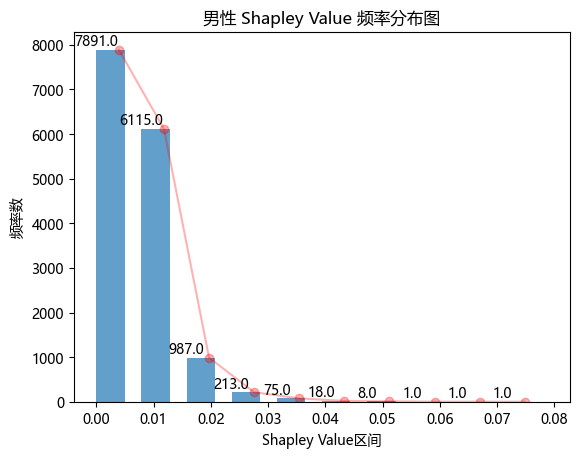

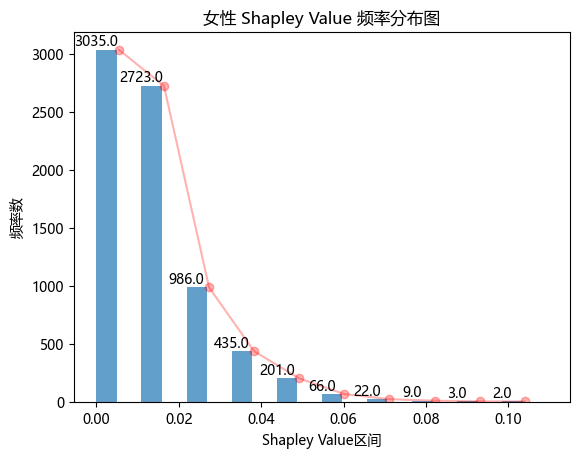

In [15]:
# 可以看到 大于 0.04 的数据比较少，说明不太合理，认为这些是不合理的数据
plt_hist_freq(shap_distance_male, 10, xlabel="Shapley Value区间", ylabel="频率数", title="男性 Shapley Value 频率分布图")
plt_hist_freq(shap_distance_female, 10, xlabel="Shapley Value区间", ylabel="频率数", title="女性 Shapley Value 频率分布图")


In [16]:
# 所以设定阈值为 t=0.04
t = 0.035
# 统计大于阈值的数量
np.sum(shap_distance_male > t), np.sum(shap_distance_female > t)

(58, 603)

In [17]:
# 统计大于阈值的 index
unfair_threshold_np_idx_shapley_value_male = np.where(shap_distance_male > t)
fair_threshold_np_idx_shapley_value_male = np.where(shap_distance_male <= t)
assert len(shap_distance_male) == len(
    unfair_threshold_np_idx_shapley_value_male[0]
) + len(fair_threshold_np_idx_shapley_value_male[0]), "和不相等"
# female
unfair_threshold_np_idx_shapley_value_female = np.where(shap_distance_female > t)
fair_threshold_np_idx_shapley_value_female = np.where(shap_distance_female <= t)
assert len(shap_distance_female) == len(
    unfair_threshold_np_idx_shapley_value_female[0]
) + len(fair_threshold_np_idx_shapley_value_female[0]), "和不相等"

In [18]:
knn_k = 7

In [19]:
# knn-male
# 使用 Knn 算法找到最近邻的 k 个样本 male
from sklearn.neighbors import NearestNeighbors

# 定义公平样本
fair_sample_iloc_in_X_train_male = idxs_iloc_in_X_train_male[
    fair_threshold_np_idx_shapley_value_male
]
fair_samples_male = X_train.iloc[fair_sample_iloc_in_X_train_male]
print("公平样本的大小", fair_samples_male.shape)

# 定义不公平样本样本
unfair_sample_iloc_in_X_train_male = idxs_iloc_in_X_train_male[
    unfair_threshold_np_idx_shapley_value_male
]
unfair_samples_male = X_train.iloc[unfair_sample_iloc_in_X_train_male]
print("不公平样本的大小", unfair_samples_male.shape)

# 定义 + 训练模型
knn = NearestNeighbors(n_neighbors=knn_k)
knn.fit(fair_samples_male)
# 寻找最近邻的样本
distances, idx_of_knn_found_in_fair_samples = knn.kneighbors(unfair_samples_male)
# 最近邻的样本
idx_of_knn_found_in_fair_samples.shape
# 如何找到 X train 上的 knn 个样本

公平样本的大小
(15252, 14)

不公平样本的大小
(58, 14)

(58, 7)

In [20]:
# knn-female
# 使用 Knn 算法找到最近邻的 k 个样本 female
from sklearn.neighbors import NearestNeighbors

# 定义公平样本
fair_sample_iloc_in_X_train_female = idxs_iloc_in_X_train_female[
    fair_threshold_np_idx_shapley_value_female
]
fair_samples_female = X_train.iloc[fair_sample_iloc_in_X_train_female]
print("公平样本的大小", fair_samples_female.shape)

# 定义不公平样本样本
unfair_sample_iloc_in_X_train_female = idxs_iloc_in_X_train_female[
    unfair_threshold_np_idx_shapley_value_female
]
unfair_samples_female = X_train.iloc[unfair_sample_iloc_in_X_train_female]
print("不公平样本的大小", unfair_samples_female.shape)

# 定义 + 训练模型
knn = NearestNeighbors(n_neighbors=knn_k)
knn.fit(fair_samples_female)
# 寻找最近邻的样本
distances, idx_of_knn_found_in_fair_samples = knn.kneighbors(unfair_samples_female)
# 最近邻的样本
idx_of_knn_found_in_fair_samples.shape
# 如何找到 X train 上的 knn 个样本

公平样本的大小
(6879, 14)

不公平样本的大小
(603, 14)

(603, 7)

In [21]:
from scipy import stats

count = 0
total = len(unfair_threshold_np_idx_shapley_value_male[0])
unfair_male_list = []
# 对于每个不公平样本进行遍历
for i in range(total):
    # 不公平样本
    unfair_sample = unfair_threshold_np_idx_shapley_value_male[0][i]
    # 映射 index
    X_train_idxs_unfair_sample = idxs_iloc_in_X_train_male[unfair_sample]
    tmp_unfair_y = y_train.iloc[X_train_idxs_unfair_sample]

    # 近邻的公平样本
    fair_samples_from_knn = idx_of_knn_found_in_fair_samples[i]
    # print(unfair_sample, fair_samples_from_knn)
    # 映射 index
    X_train_idxs_samples_from_knn = idxs_iloc_in_X_train_male[fair_samples_from_knn]
    tmp_y = y_train.iloc[X_train_idxs_samples_from_knn]

    # 统计计算
    fair_mode = stats.mode(tmp_y.values).mode
    if fair_mode != tmp_unfair_y:
        count += 1
        unfair_male_list.append(X_train_idxs_unfair_sample)
print("不同的数为", count, total)
unfair_male_list_np = np.array(unfair_male_list)
unfair_male_list_np, len(unfair_male_list_np)

不同的数为 35 58

(array([ 8357, 20620,  4822,  7389, 10662,  8160,  3787, 17671, 15407,
        19011, 16637,  5454,  3030, 20104,  2874,  1436, 18068, 10995,
          102,  3799, 13808,  9628,   773,  1161, 20511, 19465,  7720,
        22516,  3738, 15914, 15415, 14702, 13755,  6964,  4240],
       dtype=int64),
 35)

In [22]:
from scipy import stats

count = 0
total = len(unfair_threshold_np_idx_shapley_value_female[0])
unfair_female_list = []
# 对于每个不公平样本进行遍历
for i in range(total):
    # 不公平样本
    unfair_sample = unfair_threshold_np_idx_shapley_value_female[0][i]
    # 映射 index
    X_train_idxs_unfair_sample = idxs_iloc_in_X_train_female[unfair_sample]
    tmp_unfair_y = y_train.iloc[X_train_idxs_unfair_sample]

    # 近邻的公平样本
    fair_samples_from_knn = idx_of_knn_found_in_fair_samples[i]
    # print(unfair_sample, fair_samples_from_knn)
    # 映射 index
    X_train_idxs_samples_from_knn = idxs_iloc_in_X_train_female[fair_samples_from_knn]
    tmp_y = y_train.iloc[X_train_idxs_samples_from_knn]

    # 统计计算
    fair_mode = stats.mode(tmp_y.values).mode
    if fair_mode != tmp_unfair_y:
        count += 1
        unfair_female_list.append(X_train_idxs_unfair_sample)
print("不同的数为", count, total)
unfair_female_list_np = np.array(unfair_female_list)
unfair_female_list_np, len(unfair_female_list_np)

不同的数为 62 603

(array([12160, 13622,  2741, 19326, 13881, 10234,  6067,  6958,  3868,
         9836,  5089,  4307,  4840,  1872,  2699,  9615,  8115,  6159,
        11287,  7511,  1710, 21327, 16895, 17043, 17217,  2401,  1502,
        14929,  7417, 12663,  1297,  3369,  4088, 14533, 22377, 19590,
        21557,  9506, 15136, 19735, 21280,  9721, 20094, 12735, 15313,
         1422,  9777,  9750, 22366, 11425, 17340, 21385, 15975,  8038,
         1397, 19855, 11198,  8541,  9875,  7288,  7007, 17732],
       dtype=int64),
 62)

In [23]:
# 合并向量
unfair_list_np = np.concatenate((unfair_male_list_np, unfair_female_list_np))
unfair_list_np.shape

(97,)

In [24]:
y_train_fair = y_train.copy()
y_train_fair.iloc[unfair_list_np] = 1 - y_train.iloc[unfair_list_np]

In [25]:
# 查看不公平样本的 shapley value 值
pd.DataFrame(shapley_values_male[unfair_sample].reshape(1, -1), columns=X_train.columns)

,age,workclass,fnlwgt,education,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country
0,0.078044,0.004163,0.030289,-0.009009,0.077796,0.005915,0.012026,0.135015,0.002613,0.01049,-0.026883,-0.009516,-0.070223,0.00128


In [26]:
xgboost_fair, res_fair = train_model_and_test(
    X_train,
    y_train_fair,
    X_test,
    y_test,
    model_cls=xgboost.XGBRegressor,
    test_func=test_model,
    sensitive_feature=sex,
    desc="公平组",
)
res_fair

{'准确率[1.]': 0.8629337700890573,
 '精确率[1.]': 0.7670157068062827,
 '召回率[1.]': 0.6210258584145825,
 'FPR[0.]': 0.06005398110661268,
 'FNR[0.]': 0.37897414158541753,
 'F1 Score[1.]': 0.6863434059498713,
 '人口平等 差异[0.]': 0.17511988146046117,
 '人口平等 比率[1.]': 0.31183939850588943,
 '机会均等 差异[0.]': 0.08709493635706733,
 '机会均等 比率[1.]': 0.25698665440804197}

In [27]:
xgboost_origin, res_origin = train_model_and_test(
    X_train,
    y_train,
    X_test,
    y_test,
    model_cls=xgboost.XGBRegressor,
    test_func=test_model,
    sensitive_feature=sex,
    desc="原始组",
)
res_origin

{'准确率[1.]': 0.8624219469751254,
 '精确率[1.]': 0.7683765203595981,
 '召回率[1.]': 0.6159389571852479,
 'FPR[0.]': 0.05910931174089069,
 'FNR[0.]': 0.384061042814752,
 'F1 Score[1.]': 0.6837647058823529,
 '人口平等 差异[0.]': 0.16989595884523423,
 '人口平等 比率[1.]': 0.32250719180485066,
 '机会均等 差异[0.]': 0.08764799066199769,
 '机会均等 比率[1.]': 0.29597011190360795}

## 向 poe 提问

样本 `X` 根据 `sex` 分为了 `X_male` 和 `X_female`，定义 `sorted_index = np.argsort(np.sum(X_male, axis=1))` 得到 sorted_index，此时可以 `X[sorted_index]` 是 `X_male` 的子集吗

In [28]:
# 计算不同元素的个数
different_count = np.count_nonzero(y_train != y_train_fair)

print("两个数组中不同元素的个数为:", different_count)

两个数组中不同元素的个数为: 97